# Inventory Monitory at Distribution Centers

## Importing the Neccessary Libraries

In [2]:
!pip install smdebug


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [55]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import image, pyplot
import numpy as np
import random
import os
import shutil
import smdebug
import sagemaker
import boto3
import torch
from torchvision.utils import make_grid

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [4]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

#download_and_arrange_data()

## Dataset
This dataset contains images of bins containing one or more objects. The number of objects present the various classes and these are the following: 1,2,3,4,5 giving it five (5) classes.

In [5]:
image_dir = "./data/train/"
classes = os.listdir(image_dir )
print("Image Classes:", classes)

Image Classes: ['4', '2', '1', '5', '3']


### Visualizing a sample of the image

In [6]:
%matplotlib inline

In [7]:
img = image.imread('./data/train/1/00009.jpg')
img.shape

(568, 596, 3)

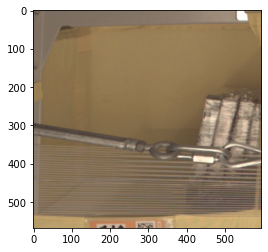

In [8]:
plt.imshow(img)

### Creating validation and test set 

In [9]:
def create_valid_test_set(image_folder, valid_ratio):
    
    for f in os.listdir(image_folder):
        valid_directory = os.path.join('data/valid', f)
        test_directory = os.path.join('data/test', f)
    
        if not os.path.exists(valid_directory):
            os.makedirs(valid_directory)
    
        if not os.path.exists(test_directory):
            os.makedirs(test_directory)
        
        files = os.listdir(image_folder + '/' + f)
        sample_size =  int(len(files) * valid_ratio)
    
        d = random.sample(files, k=sample_size)
        valid_files = d[:len(d)//2]
        test_files = d[len(d)//2:]
    
        for file in valid_files:
            shutil.move(image_folder+'/'+f+'/'+file, valid_directory+'/'+file)
        
        print('Done moving.. validation files set for class', f)
    
        for file in test_files:
            shutil.move(image_folder+'/'+f+'/'+file, test_directory+'/'+file)
        
        print('Done moving.. Test files set for class', f)
        print('\n')
        
#create_valid_test_set('data/train', 0.4)

### Uploading Dataset to s3 bucket

In [10]:
sagemaker_session = sagemaker.Session()
bucket = "inventory-monitory"
role = sagemaker.get_execution_role()

In [11]:
# inputs = sagemaker_session.upload_data(path="data", bucket=bucket)
# print("input spec (in this case, just an S3 path): {}".format(inputs))

### Visualzing sample batch

In [56]:
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

In [57]:
from train import create_data_loaders

train_loader, test_loader, validation_loader=create_data_loaders('./data/', 64, 1)

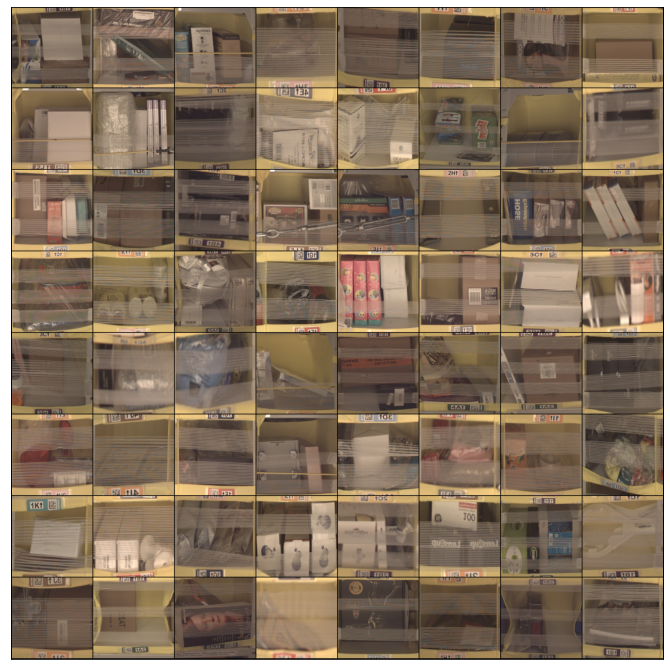

In [58]:
show_batch(train_loader)

## Model Training

In [12]:
os.environ['SM_CHANNEL_TRAINING'] = f's3://{bucket}/data'
os.environ['SM_MODEL_DIR'] = f's3://{bucket}/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = f's3://{bucket}/output/'

In [13]:
from sagemaker.pytorch import PyTorch

In [19]:
estimator = PyTorch(
        entry_point="train_2.py",
        role=role,
        py_version='py36',
        framework_version="1.8",
        instance_count=1,
        instance_type="ml.p3.2xlarge"
)

In [ ]:
estimator.fit({"training": f's3://{bucket}/data'}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-18-11-27-27-449


2023-04-18 11:27:28 Starting - Starting the training job...

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
Parameters to tune: Batch size, learning rate

##### Tuning the learning rate help fine the optimal value to reach globally minima during gradient descent.
##### Tuning the batch size help prevent the case of choosing a small batch size which can slow down training or a large batch size which can get the model stuck at local minima.

In [13]:
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [14]:
hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [15]:
estimator = PyTorch(
    entry_point="train.py",
    base_job_name='pytorch_bin_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type
)

In [20]:
tuner.fit({"training": f's3://{bucket}/data'}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.........................................................................................................................................................................................................................................................................................................................................................................................!


In [21]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics
latest_tuning_name = tuner.latest_tuning_job.name
print(latest_tuning_name)
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name=tuner.latest_tuning_job.name)

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

pytorch-training-230413-1502


,batch-size,learning-rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,"""512""",0.003278,pytorch-training-230413-1502-002-1f189c8a,Completed,161.0,2023-04-13 15:03:24+00:00,2023-04-13 15:18:30+00:00,906.0
3,"""128""",0.001113,pytorch-training-230413-1502-001-9e6b747d,Completed,153.0,2023-04-13 15:03:12+00:00,2023-04-13 15:17:43+00:00,871.0
0,"""128""",0.002141,pytorch-training-230413-1502-004-bf8f2e85,Completed,151.0,2023-04-13 15:19:43+00:00,2023-04-13 15:33:03+00:00,800.0
1,"""64""",0.001954,pytorch-training-230413-1502-003-42527211,Completed,149.0,2023-04-13 15:19:52+00:00,2023-04-13 15:33:12+00:00,800.0


In [23]:
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-04-13 15:33:16 Starting - Found matching resource for reuse
2023-04-13 15:33:16 Downloading - Downloading input data
2023-04-13 15:33:16 Training - Training image download completed. Training in progress.
2023-04-13 15:33:16 Uploading - Uploading generated training model
2023-04-13 15:33:16 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"64"',
 'learning-rate': '0.001954291722829116',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_bin_hpo-2023-04-13-15-02-00-483"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-679920891558/pytorch_bin_hpo-2023-04-13-15-02-00-483/source/sourcedir.tar.gz"'}

### Model Profiling and Debugging

In [16]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

In [17]:
rules = [
        Rule.sagemaker(rule_configs.loss_not_decreasing()),
        ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
        Rule.sagemaker(rule_configs.vanishing_gradient()),
        Rule.sagemaker(rule_configs.overfit()),
        Rule.sagemaker(rule_configs.overtraining()),
        Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    s3_output_path=f"s3://{bucket}/output/",
    collection_configs=[
        CollectionConfig(
            name="CrossEntropyLoss_output",
            parameters={
                "include_regex": "CrossEntropyLoss_output.*",
                "train.save_interval": "100",
                "eval.save_interval": "10",
                "predict.save_interval": "10"}
        )]
)

In [18]:
# TODO: Create and fit an estimator
hyperparameters = {
    "batch-size": 64,
    "lr": 0.001
}

estimator = PyTorch(
    entry_point="train.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [35]:
estimator.fit({"training": f's3://{bucket}/data'}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-14-10-26-38-755


2023-04-14 10:26:39 Starting - Starting the training job...LossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2023-04-14 10:27:30 Starting - Preparing the instances for training......
2023-04-14 10:28:31 Downloading - Downloading input data...
2023-04-14 10:29:11 Training - Downloading the training image.....................
2023-04-14 10:32:33 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-14 10:32:43,681 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-14 10:32:43,710 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-14 10:32:43,713 sagemaker_pytorch_container.training INFO     Invoking user training 

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [36]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-04-14 10:58:47.232 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:32 INFO s3_trial.py:42] Loading trial debug-output at path s3://inventory-monitory/output/pytorch-training-2023-04-14-10-26-38-755/debug-output


In [37]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

[2023-04-14 10:58:50.821 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:32 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-04-14 10:58:51.840 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:32 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


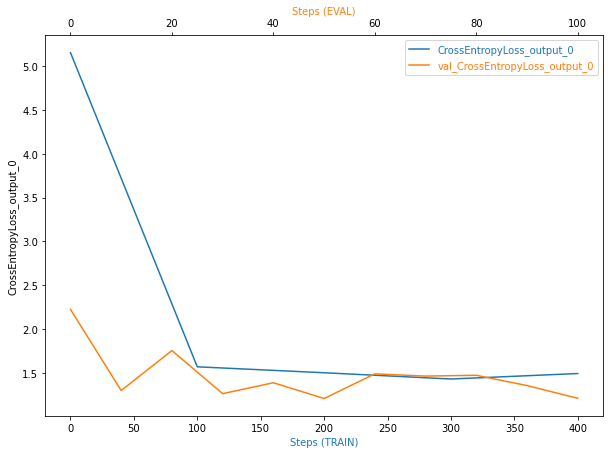

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
plot_tensor(trial, "CrossEntropyLoss_output_0")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [14]:
TrainingJobName='pytorch-training-2023-04-18-08-08-25-314'
estimator = sagemaker.estimator.Estimator.attach(TrainingJobName)


2023-04-18 09:52:37 Starting - Preparing the instances for training
2023-04-18 09:52:37 Downloading - Downloading input data
2023-04-18 09:52:37 Training - Training image download completed. Training in progress.
2023-04-18 09:52:37 Uploading - Uploading generated training model
2023-04-18 09:52:37 Completed - Training job completed


In [15]:
model_location=estimator.model_data

In [17]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='train_2.py',
                             py_version='py3',
                             framework_version='1.8')

In [18]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!

In [30]:
from train import create_data_loaders

In [72]:
train_loader, test_loader, validation_loader=create_data_loaders('./data/', 64, 1)

In [73]:
for image, target in test_loader:
    break

In [75]:
image = image.numpy()

In [45]:
response = predictor.predict(image)
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(10), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Raw prediction result:
[[-0.41606581  0.10018884  0.3084445   0.11386731 -0.0139275 ]]

Labeled predictions: 
[(0, -0.4160658121109009), (1, 0.10018884390592575), (2, 0.3084444999694824), (3, 0.11386731266975403), (4, -0.01392749510705471)]

Most likely answer: (2, 0.3084444999694824)


In [76]:
img = np.squeeze(image, axis=0)

Actual Label:  1
Predicted Label:  3


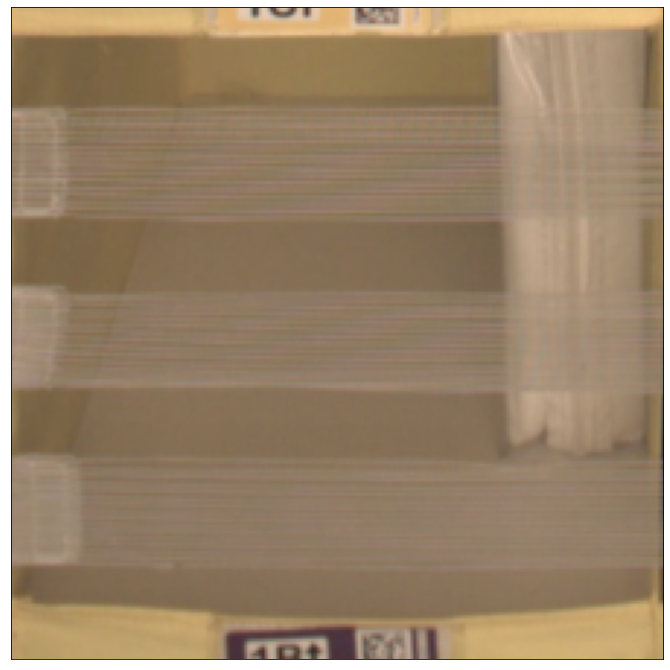

In [78]:
print('Actual Label: ', target.item()+1)
print('Predicted Label: ', labeled_predictions[0][0]+1)
show_batch(test_loader)

In [48]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-04-18-15-21-17-176
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-18-15-21-17-176


### Multi-Instance Training